In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [11]:
from src.preprocessing.preprocessing import load_and_split_data_for_vgg16, NUM_CLASSES 
from src.models.model_definition import create_vgg16_transfer_model, unfreeze_last_n_layers

In [4]:
BATCH_SIZE = 32
train_ds, val_ds, test_ds, ds_info = load_and_split_data_for_vgg16(batch_size=BATCH_SIZE)

In [5]:
model = create_vgg16_transfer_model(input_shape=(224, 224, 3))
model.summary()

Model: "VGG16_Transfer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 14,979,396
Trainable params: 264,708
Non-trainable params: 14,714,688
__________________________________

In [6]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,        
    restore_best_weights=True
)


In [7]:
model_checkpoint = ModelCheckpoint(
    filepath='models/best_vgg16_4class.h5', 
    monitor='val_accuracy', 
    mode='max', 
    save_best_only=True
)

In [8]:
with tf.device('/GPU:0'):
    history1 = model.fit(
        train_ds,
        epochs=10,
        validation_data=val_ds,
        callbacks=[early_stopping, model_checkpoint]
    )
model.save('models/final_stage1_vgg16_4class.h5')

Epoch 1/10
65/65 [==============================] - 68s 666ms/step - loss: 1.7692 - accuracy: 0.7333 - val_loss: 0.3804 - val_accuracy: 0.9095
Epoch 2/10
65/65 [==============================] - 75s 679ms/step - loss: 0.6414 - accuracy: 0.8402 - val_loss: 0.3045 - val_accuracy: 0.9095
Epoch 3/10
65/65 [==============================] - 63s 607ms/step - loss: 0.4352 - accuracy: 0.8700 - val_loss: 0.2796 - val_accuracy: 0.9284
Epoch 4/10
65/65 [==============================] - 63s 670ms/step - loss: 0.3131 - accuracy: 0.8897 - val_loss: 0.2651 - val_accuracy: 0.9221
Epoch 5/10
65/65 [==============================] - 57s 556ms/step - loss: 0.2747 - accuracy: 0.9085 - val_loss: 0.2378 - val_accuracy: 0.9221
Epoch 6/10
65/65 [==============================] - 58s 592ms/step - loss: 0.2417 - accuracy: 0.9138 - val_loss: 0.2270 - val_accuracy: 0.9284
Epoch 7/10
65/65 [==============================] - 52s 532ms/step - loss: 0.2256 - accuracy: 0.9220 - val_loss: 0.2406 - val_accuracy: 0.9263

In [12]:
model = unfreeze_last_n_layers(model, fine_tune_at=4, lr=1e-5)
model.summary()

Model: "VGG16_Transfer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 14,979,396
Trainable params: 7,344,132
Non-trainable params: 7,635,264
_________________________________

In [13]:
with tf.device('/GPU:0'):
    history2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25,
        initial_epoch=history1.epoch[-1]+1,
        callbacks=[early_stopping, model_checkpoint]
    )
model.save('models/final_vgg16_4class.h5')

Epoch 11/25
65/65 [==============================] - 64s 653ms/step - loss: 0.1492 - accuracy: 0.9490 - val_loss: 0.2068 - val_accuracy: 0.9432
Epoch 12/25
65/65 [==============================] - 62s 632ms/step - loss: 0.1221 - accuracy: 0.9543 - val_loss: 0.2093 - val_accuracy: 0.9516
Epoch 13/25
65/65 [==============================] - 57s 562ms/step - loss: 0.1331 - accuracy: 0.9576 - val_loss: 0.2363 - val_accuracy: 0.9432
Epoch 14/25
65/65 [==============================] - 52s 548ms/step - loss: 0.1041 - accuracy: 0.9639 - val_loss: 0.1822 - val_accuracy: 0.9474
Epoch 15/25
65/65 [==============================] - 52s 552ms/step - loss: 0.0756 - accuracy: 0.9716 - val_loss: 0.2077 - val_accuracy: 0.9389
Epoch 16/25
65/65 [==============================] - 51s 544ms/step - loss: 0.0870 - accuracy: 0.9668 - val_loss: 0.2044 - val_accuracy: 0.9516
Epoch 17/25
65/65 [==============================] - 51s 541ms/step - loss: 0.0694 - accuracy: 0.9750 - val_loss: 0.2094 - val_accuracy:

In [19]:
model.save('models/final_vgg16_4class_compressed.h5', include_optimizer=False)

In [14]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Trening Accuracy')
    plt.plot(epochs_range, val_acc, label='Walidacja Accuracy')
    plt.legend(loc='lower right')
    plt.title('Dokładność (Accuracy)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Trening Loss')
    plt.plot(epochs_range, val_loss, label='Walidacja Loss')
    plt.legend(loc='upper right')
    plt.title('Strata (Loss)')
    plt.grid(True)
    
    plt.show()

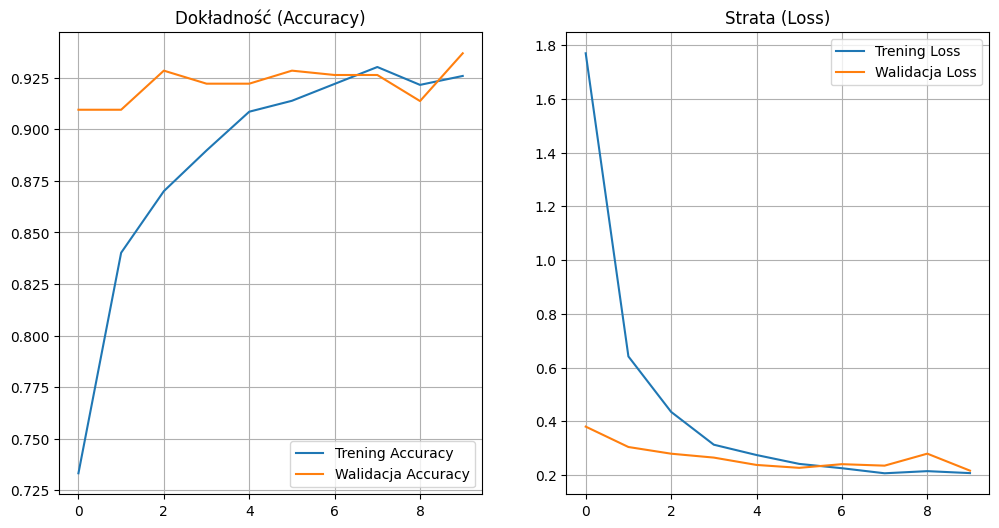

In [15]:
plot_training_history(history1)

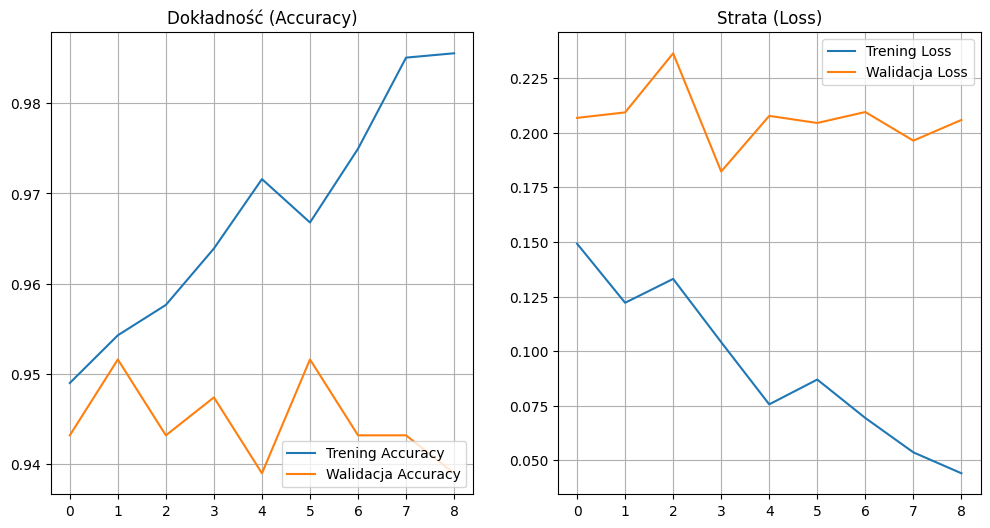

In [16]:
plot_training_history(history2)